# Construção do indicador - Taxa de desemprego por tipo

Jupyter Notebook para analisar os dados da Pesquisa de Emprego e Desemprego conforme estão em `raw/DIEPS/bases/ped-parquet/NovaPEDDF2018.parquet`.

## Leitura do MinIO

Leitura de todos os arquivos carregados do MinIO.

In [272]:
import pyarrow.dataset as pds
import pyarrow.parquet as pq
import pyarrow as pa
import s3fs
import pandas as pd

In [273]:
ACCESS_KEY = 'NGMdNXl06SbqaEB7FnlI'
SECRET_KEY = 'WLjEZszmcLVvdbeoat7kBz2Pagc77xlKMVQNL04y'
MINIO_HOST = 'http://minio:9000'

In [274]:
minio = s3fs.S3FileSystem(key=ACCESS_KEY, # change default key 
                        secret=SECRET_KEY, # change default secret
                        use_ssl=False,
                        client_kwargs={
                            'endpoint_url': MINIO_HOST} # change ip
                        )

# Verifiacação da conexão 
objects = minio.head('raw/DIEPS/bases/nova-ped-parquet')
objects

b''

## Carregamento em dataframe

Os arquivos parquet listados acima serão carregados em um único dataframe.

In [275]:
from io import BytesIO
fs = s3fs.core.S3FileSystem()

part = pds.partitioning(
    pa.schema([
        ('year', pa.int16())
    ])
)
dataset = pq.ParquetDataset(
    'raw/DIEPS/bases/nova-ped-parquet',
    filesystem=minio,
    partitioning=part
)


# dt = dataset.to_table()
# dt
dataset.files

['raw/DIEPS/bases/nova-ped-parquet/2021/PED-DF_2021.parquet',
 'raw/DIEPS/bases/nova-ped-parquet/2022/PED-DF_2022.parquet',
 'raw/DIEPS/bases/nova-ped-parquet/2023/PED-DF_2023.parquet',
 'raw/DIEPS/bases/nova-ped-parquet/2024/PED-DF_2024.parquet']

In [276]:
fields = []
for field in dataset.schema:
    fields.append(field.name)
#del fields[83]
fields

['ANO_MES',
 'conglom',
 'NUM_DOMICILIO',
 'NUM_FAMILIA',
 'NUM_INDIVIDUO',
 'C000',
 'C030',
 'C040',
 'C050',
 'C061',
 'C062',
 'C070',
 'D010',
 'D0211',
 'D0212',
 'D0221',
 'D0222',
 'D0231',
 'D0232',
 'D0241',
 'D0242',
 'D0251',
 'D0252',
 'E000',
 'M011',
 'M012',
 'M021',
 'M022',
 'M031',
 'M032',
 'M041',
 'M042',
 'M051',
 'M052',
 'E010',
 'E020',
 'E030',
 'E040',
 'E050',
 'E060',
 'E070',
 'E080',
 'E090',
 'F010',
 'F020',
 'F030',
 'F040',
 'F050',
 'F061',
 'F062',
 'F063',
 'F070',
 'F080',
 'F090',
 'F100',
 'F111',
 'F112',
 'F113',
 'F120',
 'F130',
 'F141',
 'F142',
 'F143',
 'F150',
 'F160',
 'F170',
 'F180',
 'F190',
 'F201',
 'F202',
 'F210',
 'F220',
 'F230',
 'F240',
 'F250',
 'F260',
 'F270',
 'F280',
 'F290',
 'F300',
 'F310',
 'F320',
 'F330',
 'F340',
 'F350',
 'F360',
 'F370',
 'F380',
 'F390',
 'F400',
 'F410',
 'F420',
 'F430',
 'F440',
 'F451',
 'F452',
 'F453',
 'F461',
 'F462',
 'F463',
 'F470',
 'F481',
 'F482',
 'F483',
 'F484',
 'F485',
 'F49

In [277]:
# # Converte para pandas
fields_final = fields[0:82] + fields[83:]
# len(fields_final)

#df = dataset.read(columns=fields_final).to_pandas()
#import re

# Set the columns list to all fields that match the regex r'(C010)|F[0-9]*'
#fields = [field for field in fields_final if re.match(r'(C030)|(F[0-9]*)|(year)', field)]
#fields = [field for field in fields_final if re.match(r'(C030)|(SIT)|(year)', field)]
#fields = fields[['C']]

df = dataset.read(columns=fields_final).to_pandas()

df[['C030', 'F010', 'F030', 'F070',  'year']]
df.rename(columns={'SIT': 'sit'}, inplace=True)

#df[(df['year'] == 2018) & (df['SIT'] != 'Ocupado')]

In [278]:
df2 = df.copy()
df2.count()

ANO_MES          261425
conglom          261425
NUM_DOMICILIO    261425
NUM_FAMILIA      261425
NUM_INDIVIDUO    261425
                  ...  
sit              261425
POS              261425
CNAE             261425
SETOR_CNAE       261425
year             261425
Length: 174, dtype: int64

In [279]:
desempregado = list(df2['sit'].cat.categories)
desempregado

['Indefinido',
 'Desemprego Oculto pelo Trabalho Precário',
 'Desemprego Aberto',
 'Desemprego Oculto pelo Desalento',
 'Ocupado',
 'Inativo com Trabalho Excepcional',
 'Inativo Puro',
 'Não se aplica (menor de 14 anos)']

In [280]:
# População economicamente ativa (PEA)
pea = pd.DataFrame(df2[
    (
        (df2['sit'] != 'Inativo com Trabalho Excepcional') &
        (df2['sit'] != 'Inativo Puro') &
        (df2['sit'] != 'Indefinido') 
    ) &
    (
        (df2['F010'] == 'Sim') | # Procurou trabalho nos últimos 30 dias?
        (df2['F030'] == 'Sim') | # Procurou trabalho nos últimos 12 meses?
        (df2['F070'] != 'Não se aplica') # Fez trabalho nos últimos 7 dias?
    )
].groupby(['year'])['F010'].count())
pea.reset_index(inplace=True)
pea

,year,F010
0,2021,35931
1,2022,36386
2,2023,35309
3,2024,34520


In [281]:
# Desempregados
pea_desempregados = pd.DataFrame(df2[
    (
        (df2['sit'] != 'Inativo com Trabalho Excepcional') &
        (df2['sit'] != 'Inativo Puro') &
        (df2['sit'] != 'Ocupado')
    ) &
    (
        (df2['F010'] == 'Sim') |
        (df2['F030'] == 'Sim') &
        (df2['F070'] != 'Não se aplica')
    )].groupby(['year', 'sit'])['F010'].count())

pea_desempregados.reset_index(inplace=True)
pea_desempregados

/tmp/ipykernel_181/3276007944.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  )].groupby(['year', 'sit'])['F010'].count())


,year,sit,F010
0,2021,Indefinido,0
1,2021,Desemprego Oculto pelo Trabalho Precário,698
2,2021,Desemprego Aberto,5589
3,2021,Desemprego Oculto pelo Desalento,0
4,2021,Ocupado,0
5,2021,Inativo com Trabalho Excepcional,0
6,2021,Inativo Puro,0
7,2021,Não se aplica (menor de 14 anos),0
8,2022,Indefinido,0
9,2022,Desemprego Oculto pelo Trabalho Precário,604


In [282]:
df3 = pea.merge(pea_desempregados, on='year')
df3.rename(columns={
    'F010_x': 'PEA',
    'F010_y': 'Desempregados',
    'sit': 'Situação',
    'year': 'Ano'
}, inplace=True)

df3 = df3.loc[(df3!=0).all(axis=1)]
df3

,Ano,PEA,Situação,Desempregados
1,2021,35931,Desemprego Oculto pelo Trabalho Precário,698
2,2021,35931,Desemprego Aberto,5589
9,2022,36386,Desemprego Oculto pelo Trabalho Precário,604
10,2022,36386,Desemprego Aberto,5008
17,2023,35309,Desemprego Oculto pelo Trabalho Precário,637
18,2023,35309,Desemprego Aberto,4930
25,2024,34520,Desemprego Oculto pelo Trabalho Precário,614
26,2024,34520,Desemprego Aberto,4520


In [ ]:
# Coluna com a taxa de desemprego
df3['Taxa de Desemprego'] = (df3['Desempregados'] / df3['PEA']) * 100
df3

,Ano,PEA,Situação,Desempregados,Taxa de Desemprego
1,2021,35931,Desemprego Oculto pelo Trabalho Precário,698,1.942612
2,2021,35931,Desemprego Aberto,5589,15.554813
9,2022,36386,Desemprego Oculto pelo Trabalho Precário,604,1.659979
10,2022,36386,Desemprego Aberto,5008,13.763535
17,2023,35309,Desemprego Oculto pelo Trabalho Precário,637,1.804073
18,2023,35309,Desemprego Aberto,4930,13.962446
25,2024,34520,Desemprego Oculto pelo Trabalho Precário,614,1.778679
26,2024,34520,Desemprego Aberto,4520,13.093859


In [284]:
# campos relevantes
final_df = df3.pivot(index='Ano', columns='Situação', values='Taxa de Desemprego')
final_df

Situação,Desemprego Oculto pelo Trabalho Precário,Desemprego Aberto
Ano,,
2021,1.942612,15.554813
2022,1.659979,13.763535
2023,1.804073,13.962446
2024,1.778679,13.093859


# Analise

Gráficos para análise e possível identificação de indicadores nos dados

Taxa de desemprego 

In [285]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

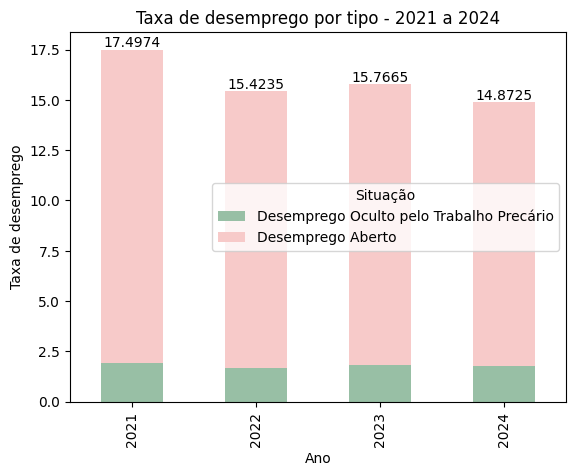

In [ ]:

# Cores
pastel_colors = ['#98BFA5', '#F7CAC9', '#87CEEB', '#ADD8E6', '#D2B48C']

# Realiza o agupamento por cor e sexo
fig = plt.figure(dpi=100)

ax = final_df.plot(kind='bar', stacked=True, color=pastel_colors)
ax.bar_label(ax.containers[-1])

# Apresenta o gráfico
plt.title('Taxa de desemprego por tipo - 2021 a 2024')
plt.ylabel('Taxa de desemprego')
plt.show()
